[Transfer learning with a pretrained ConvNet  \|  TensorFlow Core](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ja)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### データの前処理

In [2]:
!pip install -q tensorflow_datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)

/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4M4X5P/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


最初の2つの画像を表示する

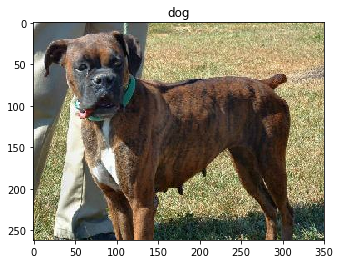

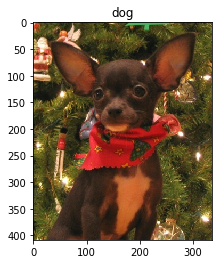

In [5]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### 画像のフォーマット

1. 画像は 160x160 に変形して統一させる
2. 要素を 0〜255 から -1〜1 に写像する (0〜255 を 127.5 で割って 0〜2 にしたら -1 する)

In [6]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [7]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

バッチサイズは32。訓練データはシャッフルしてから、バッチサイズ分の画像を取得する。

`.batch()` の返り値はジェネレータ。

`next(iter(xs))` でジェネレータから値を取得する（`for in` でも可）。

`image_batch.shape` の読み方は、160x160 の 3 チャネル(RGB)画像が 32 枚ある。

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

### 事前学習済みモデルから基本となるモデルを作成する

MobileNetV2 について

- `include_top=False` : 最上位層（分類層）を含まないことで、特徴量抽出モデルにする
- MobileNetV2 の層の重みは固定する (`model.trainable = False`)

In [9]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### 特徴量抽出

- GlobalAverage はチャンネル全体の平均を意味する
- `GlobalAveragePooling2D` はデータ量がチャネル数まで減る（例えば 160x160x3 は 3 になる。上のモデルでは 5x5x1280 は 1280 になる。）
- つまり、`Flatten` の代わりとして使える + データ量が減るメリットがある

In [11]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1)
])

### モデルのコンパイル



In [12]:
#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### モデルの訓練

In [13]:
initial_epochs = 10

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 53s 91ms/step - loss: 0.4017 - accuracy: 0.7995 - val_loss: 0.1745 - val_accuracy: 0.9054
Epoch 2/10
582/582 [==============================] - 46s 79ms/step - loss: 0.2062 - accuracy: 0.9147 - val_loss: 0.1362 - val_accuracy: 0.9278
Epoch 3/10
582/582 [==============================] - 46s 79ms/step - loss: 0.1640 - accuracy: 0.9333 - val_loss: 0.1203 - val_accuracy: 0.9351
Epoch 4/10
582/582 [==============================] - 45s 78ms/step - loss: 0.1519 - accuracy: 0.9363 - val_loss: 0.1083 - val_accuracy: 0.9454
Epoch 5/10
582/582 [==============================] - 46s 79ms/step - loss: 0.1423 - accuracy: 0.9425 - val_loss: 0.1106 - val_accuracy: 0.9424
Epoch 6/10
582/582 [==============================] - 46s 79ms/step - loss: 0.1312 - accuracy: 0.9472 - val_loss: 0.1155 - val_accuracy: 0.9411
Epoch 7/10
582/582 [==============================] - 45s 77ms/step - loss: 0.1315 - accuracy: 0.9450 - val_loss: 0.1090 - val_accuracy:

### 学習曲線

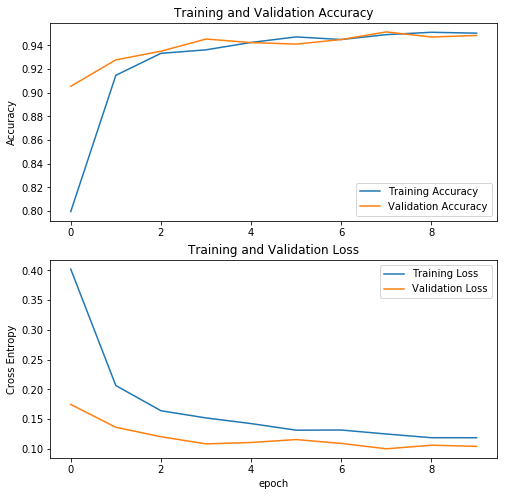

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## ファインチューニング (Fine tuning)

転移学習では事前学習済みモデルの層の重みを固定したが、ファインチューニングでは変更させる。

In [15]:
base_model.trainable = True

In [16]:
# 事前学習済みモデルは155層から構成されている
print("Number of layers in the base model: ", len(base_model.layers))

# 1〜100層は固定し、101〜155層は更新可能にする。
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# 更新可能な層の数
print("Number of trainable layers", len(model.trainable_variables))

Number of layers in the base model:  155
Number of trainable layers 58


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


モデルの再学習

In [18]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 53s 92ms/step - loss: 0.0923 - accuracy: 0.9641 - val_loss: 0.0771 - val_accuracy: 0.9785
Epoch 11/20
582/582 [==============================] - 47s 81ms/step - loss: 0.0327 - accuracy: 0.9882 - val_loss: 0.0936 - val_accuracy: 0.9789
Epoch 12/20
582/582 [==============================] - 47s 80ms/step - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0962 - val_accuracy: 0.9811
Epoch 13/20
582/582 [==============================] - 47s 81ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0894 - val_accuracy: 0.9815
Epoch 14/20
582/582 [==============================] - 47s 81ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.1226 - val_accuracy: 0.9802
Epoch 15/20
582/582 [==============================] - 49s 83ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.1693 - val_accuracy: 0.9785
Epoch 16/20
582/582 [==============================] - 47s 82ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.1218 - val_ac

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

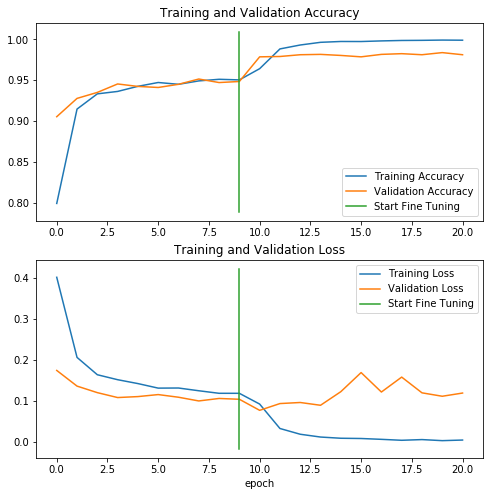

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### まとめ

- 事前学習済みモデルは特徴量抽出に使うのが基本
- 事前学習済みモデルをファインチューニングすることで精度がよくなる（場合がある）